# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 32  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] /5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29702.923828125
iteration 0 loss 18298.8671875


iteration 500 loss 191.6780548095703


iteration 1000 loss 170.82150268554688


iteration 1500 loss 146.31529235839844


iteration 2000 loss 99.697998046875


iteration 2500 loss 22.033296585083008


iteration 3000 loss 10.133159637451172


iteration 3500 loss 8.369393348693848


iteration 4000 loss 6.558860778808594


iteration 4500 loss 5.134522438049316


iteration 5000 loss 3.964911699295044


iteration 5500 loss 3.626978874206543


iteration 6000 loss 3.051868200302124


iteration 6500 loss 2.6556284427642822


iteration 7000 loss 2.3173866271972656


iteration 7500 loss 19.145397186279297


iteration 8000 loss 2.0899391174316406


iteration 8500 loss 1.8822178840637207


iteration 9000 loss 1.7253679037094116


iteration 9500 loss 1.583715558052063


iteration 10000 loss 2.5271873474121094


iteration 10500 loss 1.4771510362625122


iteration 11000 loss 1.3653168678283691


iteration 11500 loss 1.2741880416870117


iteration 12000 loss 1.461818814277649


iteration 12500 loss 1.2416962385177612


iteration 13000 loss 1.1607941389083862


iteration 13500 loss 1.096171259880066


iteration 14000 loss 29.558897018432617


iteration 14500 loss 1.0940582752227783


iteration 15000 loss 1.0192419290542603


iteration 15500 loss 0.9672729969024658


iteration 16000 loss 0.9210720658302307


iteration 16500 loss 0.9539931416511536


iteration 17000 loss 0.8975154757499695


iteration 17500 loss 0.8591975569725037


iteration 18000 loss 2.15555739402771


iteration 18500 loss 0.8560587763786316


iteration 19000 loss 0.812163770198822


iteration 19500 loss 0.7811639308929443


iteration 20000 loss 0.9540109038352966


iteration 20500 loss 0.7920038104057312


iteration 21000 loss 0.752273440361023


iteration 21500 loss 0.7247271537780762


iteration 22000 loss 0.8646277189254761


iteration 22500 loss 0.7252200841903687


iteration 23000 loss 0.6931148171424866


iteration 23500 loss 0.6703410148620605


iteration 24000 loss 0.7481681704521179


iteration 24500 loss 0.6778944134712219


iteration 25000 loss 0.6505657434463501


iteration 25500 loss 0.6306946873664856


iteration 26000 loss 0.6391862630844116


iteration 26500 loss 0.6118937134742737


iteration 27000 loss 202.37106323242188


iteration 27500 loss 0.6330620050430298


iteration 28000 loss 0.599828839302063


iteration 28500 loss 0.581112265586853


iteration 29000 loss 31.045320510864258


iteration 29500 loss 0.5713938474655151


iteration 30000 loss 0.5531536936759949


iteration 30500 loss 0.5943692326545715


iteration 31000 loss 0.5525635480880737


iteration 31500 loss 0.5356086492538452


iteration 32000 loss 0.7675216794013977


iteration 32500 loss 0.5333577990531921


iteration 33000 loss 0.516562283039093


iteration 33500 loss 1.2132267951965332


iteration 34000 loss 0.5222330689430237


iteration 34500 loss 0.5031462907791138


iteration 35000 loss 0.49160438776016235


iteration 35500 loss 0.5066168308258057


iteration 36000 loss 0.48686906695365906


iteration 36500 loss 0.4758107364177704


iteration 37000 loss 0.5041494965553284


iteration 37500 loss 0.47775620222091675


iteration 38000 loss 0.4654119908809662


iteration 38500 loss 0.4810918867588043


iteration 39000 loss 0.4582958519458771


iteration 39500 loss 0.4606861174106598


iteration 40000 loss 0.45498085021972656


iteration 40500 loss 0.4424063265323639


iteration 41000 loss 0.4577869474887848


iteration 41500 loss 0.43685251474380493


iteration 42000 loss 44.33799743652344


iteration 42500 loss 0.43175214529037476


iteration 43000 loss 0.423814594745636


iteration 43500 loss 0.44455671310424805


iteration 44000 loss 0.4219604730606079


iteration 44500 loss 0.41264793276786804


iteration 45000 loss 0.41124558448791504


iteration 45500 loss 1.0459532737731934


iteration 46000 loss 0.4064895510673523


iteration 46500 loss 0.3978658616542816


iteration 47000 loss 0.4071371555328369


iteration 47500 loss 0.3950887620449066


iteration 48000 loss 0.40874922275543213


iteration 48500 loss 0.3892648220062256


iteration 49000 loss 0.42244452238082886


iteration 49500 loss 0.3879585862159729


iteration 50000 loss 0.3799152374267578


iteration 50500 loss 0.37787824869155884


iteration 51000 loss 0.3790801763534546


iteration 51500 loss 0.38269880414009094


iteration 52000 loss 0.3705718517303467


iteration 52500 loss 0.3736366629600525


iteration 53000 loss 0.3682633340358734


iteration 53500 loss 0.3649868965148926


iteration 54000 loss 58.12471008300781


iteration 54500 loss 0.35983553528785706


iteration 55000 loss 0.37393513321876526


iteration 55500 loss 0.3532828390598297


iteration 56000 loss 0.36020222306251526


iteration 56500 loss 0.3488560914993286


iteration 57000 loss 0.3673052489757538


iteration 57500 loss 0.3484058380126953


iteration 58000 loss 0.392767071723938


iteration 58500 loss 0.34284496307373047


iteration 59000 loss 0.5946930646896362


iteration 59500 loss 0.34011802077293396


iteration 60000 loss 0.4610583782196045


iteration 60500 loss 0.3349975049495697


iteration 61000 loss 0.3364952504634857


iteration 61500 loss 0.3286857604980469


iteration 62000 loss 0.3294312357902527


iteration 62500 loss 0.32964715361595154


iteration 63000 loss 0.4741736650466919


iteration 63500 loss 0.32267093658447266


iteration 64000 loss 0.3226459324359894


iteration 64500 loss 0.3239307701587677


iteration 65000 loss 0.3416714668273926


iteration 65500 loss 0.3152640461921692


iteration 66000 loss 0.3153492212295532


iteration 66500 loss 0.3174375295639038


iteration 67000 loss 0.31820327043533325


iteration 67500 loss 0.3541595935821533


iteration 68000 loss 0.33784395456314087


iteration 68500 loss 0.3066262900829315


iteration 69000 loss 0.304657518863678


iteration 69500 loss 0.3035855293273926


iteration 70000 loss 0.3023410141468048


iteration 70500 loss 0.3026200532913208


iteration 71000 loss 0.3046896755695343


iteration 71500 loss 0.910034716129303


iteration 72000 loss 0.32133933901786804


iteration 72500 loss 0.3237205743789673


iteration 73000 loss 0.8044842481613159


iteration 73500 loss 19.980058670043945


iteration 74000 loss 0.29160892963409424


iteration 74500 loss 0.2921005189418793


iteration 75000 loss 0.29125598073005676


iteration 75500 loss 0.2898746430873871


iteration 76000 loss 0.288729190826416


iteration 76500 loss 0.2868945896625519


iteration 77000 loss 0.28520798683166504


iteration 77500 loss 0.2838570773601532


iteration 78000 loss 0.2820163071155548


iteration 78500 loss 0.28070199489593506


iteration 79000 loss 0.3226996064186096


iteration 79500 loss 0.3146504759788513


iteration 80000 loss 0.2841992974281311


iteration 80500 loss 0.28104549646377563


iteration 81000 loss 0.2773846387863159


iteration 81500 loss 0.2760654091835022


iteration 82000 loss 0.2751670777797699


iteration 82500 loss 0.27270475029945374


iteration 83000 loss 0.2716366648674011


iteration 83500 loss 0.2697862386703491


iteration 84000 loss 0.4241747558116913


iteration 84500 loss 0.27133020758628845


iteration 85000 loss 0.26804184913635254


iteration 85500 loss 0.26606813073158264


iteration 86000 loss 0.2655301094055176


iteration 86500 loss 0.26626214385032654


iteration 87000 loss 0.26358291506767273


iteration 87500 loss 0.2659246623516083


iteration 88000 loss 0.26286154985427856


iteration 88500 loss 11.37336254119873


iteration 89000 loss 0.2626173496246338


iteration 89500 loss 0.26060351729393005


iteration 90000 loss 0.2581739127635956


iteration 90500 loss 0.3313237130641937


iteration 91000 loss 0.25952786207199097


iteration 91500 loss 0.25676581263542175


iteration 92000 loss 0.25665727257728577


iteration 92500 loss 0.2597092390060425


iteration 93000 loss 0.2668690085411072


iteration 93500 loss 2.29348087310791


iteration 94000 loss 0.5777029395103455


iteration 94500 loss 0.2704746425151825


iteration 95000 loss 0.2503810524940491


iteration 95500 loss 0.25484681129455566


iteration 96000 loss 0.53794264793396


iteration 96500 loss 0.24898554384708405


iteration 97000 loss 0.2479710876941681


iteration 97500 loss 0.24694198369979858


iteration 98000 loss 0.24535995721817017


iteration 98500 loss 0.3232763111591339


iteration 99000 loss 0.24613600969314575


iteration 99500 loss 0.24853387475013733


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.33745360374450684


iteration 100500 loss 0.24472379684448242


iteration 101000 loss 0.24272634088993073


iteration 101500 loss 0.24141830205917358


iteration 102000 loss 0.2404049038887024


iteration 102500 loss 0.23949256539344788


iteration 103000 loss 0.23856566846370697


iteration 103500 loss 0.23754949867725372


iteration 104000 loss 0.23713676631450653


iteration 104500 loss 0.23587772250175476


iteration 105000 loss 0.23503798246383667


iteration 105500 loss 0.24728256464004517


iteration 106000 loss 0.23358026146888733


iteration 106500 loss 0.23284916579723358


iteration 107000 loss 0.2353789210319519


iteration 107500 loss 0.23137794435024261


iteration 108000 loss 0.23063121736049652


iteration 108500 loss 0.22974969446659088


iteration 109000 loss 0.22925814986228943


iteration 109500 loss 0.22858455777168274


iteration 110000 loss 0.22780920565128326


iteration 110500 loss 0.22725239396095276


iteration 111000 loss 0.22691503167152405


iteration 111500 loss 0.22630555927753448


iteration 112000 loss 0.22529453039169312


iteration 112500 loss 0.22460709512233734


iteration 113000 loss 0.22407491505146027


iteration 113500 loss 0.2234213501214981


iteration 114000 loss 0.22274169325828552


iteration 114500 loss 0.22215111553668976


iteration 115000 loss 0.22151219844818115


iteration 115500 loss 0.22092661261558533


iteration 116000 loss 0.22029262781143188


iteration 116500 loss 0.21992255747318268


iteration 117000 loss 0.2191222608089447


iteration 117500 loss 0.21855157613754272


iteration 118000 loss 0.2179526835680008


iteration 118500 loss 0.21746256947517395


iteration 119000 loss 0.21689781546592712


iteration 119500 loss 0.21620070934295654


iteration 120000 loss 0.8708433508872986


iteration 120500 loss 0.21505729854106903


iteration 121000 loss 0.2169763594865799


iteration 121500 loss 0.21399660408496857


iteration 122000 loss 0.2133975476026535


iteration 122500 loss 0.21353811025619507


iteration 123000 loss 0.21229533851146698


iteration 123500 loss 0.2118949592113495


iteration 124000 loss 0.21116945147514343


iteration 124500 loss 0.21073803305625916


iteration 125000 loss 0.21002916991710663


iteration 125500 loss 0.5725103616714478


iteration 126000 loss 0.2089226245880127


iteration 126500 loss 0.21062494814395905


iteration 127000 loss 0.20787860453128815


iteration 127500 loss 0.2073373943567276


iteration 128000 loss 0.20696872472763062


iteration 128500 loss 0.2063259482383728


iteration 129000 loss 0.2065252810716629


iteration 129500 loss 0.2053220123052597


iteration 130000 loss 0.20486393570899963


iteration 130500 loss 0.2044728398323059


iteration 131000 loss 0.2038610279560089


iteration 131500 loss 0.20338983833789825


iteration 132000 loss 0.20307493209838867


iteration 132500 loss 0.20244917273521423


iteration 133000 loss 0.20192337036132812


iteration 133500 loss 0.20150452852249146


iteration 134000 loss 0.20192760229110718


iteration 134500 loss 0.20068377256393433


iteration 135000 loss 0.2000887393951416


iteration 135500 loss 0.2013142704963684


iteration 136000 loss 0.1991976797580719


iteration 136500 loss 0.19874203205108643


iteration 137000 loss 0.19936703145503998


iteration 137500 loss 0.19783081114292145


iteration 138000 loss 0.8121885657310486


iteration 138500 loss 0.19693149626255035


iteration 139000 loss 0.21516257524490356


iteration 139500 loss 0.19603417813777924


iteration 140000 loss 0.1958475559949875


iteration 140500 loss 0.19513382017612457


iteration 141000 loss 0.19708232581615448


iteration 141500 loss 0.1943034827709198


iteration 142000 loss 0.19384676218032837


iteration 142500 loss 0.19353944063186646


iteration 143000 loss 0.19304755330085754


iteration 143500 loss 0.19339165091514587


iteration 144000 loss 0.19223955273628235


iteration 144500 loss 0.1923055648803711


iteration 145000 loss 0.19145949184894562


iteration 145500 loss 0.1909862607717514


iteration 146000 loss 0.19066710770130157


iteration 146500 loss 0.19018082320690155


iteration 147000 loss 0.19286422431468964


iteration 147500 loss 0.18938808143138885


iteration 148000 loss 0.1970754861831665


iteration 148500 loss 0.1885957270860672


iteration 149000 loss 0.1882692575454712


iteration 149500 loss 0.18781979382038116


iteration 150000 loss 0.18739427626132965


iteration 150500 loss 0.1870591789484024


iteration 151000 loss 0.18679115176200867


iteration 151500 loss 0.18629640340805054


iteration 152000 loss 0.18588972091674805


iteration 152500 loss 0.18550549447536469


iteration 153000 loss 0.18514128029346466


iteration 153500 loss 0.1847672015428543


iteration 154000 loss 0.184398353099823


iteration 154500 loss 0.1841055154800415


iteration 155000 loss 0.1836480349302292


iteration 155500 loss 0.18358132243156433


iteration 156000 loss 0.1828882247209549


iteration 156500 loss 0.18267987668514252


iteration 157000 loss 0.18218956887722015


iteration 157500 loss 0.1817961037158966


iteration 158000 loss 0.18149589002132416


iteration 158500 loss 0.18111348152160645


iteration 159000 loss 0.18082617223262787


iteration 159500 loss 0.1804189234972


iteration 160000 loss 0.18040065467357635


iteration 160500 loss 0.1797841191291809


iteration 161000 loss 0.17941582202911377


iteration 161500 loss 0.17912860214710236


iteration 162000 loss 0.17874334752559662


iteration 162500 loss 0.1785988062620163


iteration 163000 loss 0.17809154093265533


iteration 163500 loss 0.3290751278400421


iteration 164000 loss 0.17740459740161896


iteration 164500 loss 0.17772161960601807


iteration 165000 loss 0.17675642669200897


iteration 165500 loss 0.17650897800922394


iteration 166000 loss 0.1760898381471634


iteration 166500 loss 0.1758592426776886


iteration 167000 loss 0.17584294080734253


iteration 167500 loss 0.17510917782783508


iteration 168000 loss 0.18132047355175018


iteration 168500 loss 0.17450173199176788


iteration 169000 loss 0.17412979900836945


iteration 169500 loss 0.1738821566104889


iteration 170000 loss 0.175502210855484


iteration 170500 loss 0.17325802147388458


iteration 171000 loss 0.17287057638168335


iteration 171500 loss 0.20296938717365265


iteration 172000 loss 0.1722756177186966


iteration 172500 loss 0.17369209229946136


iteration 173000 loss 0.1717037856578827


iteration 173500 loss 0.17136161029338837


iteration 174000 loss 0.17111726105213165


iteration 174500 loss 0.17150431871414185


iteration 175000 loss 0.17049382627010345


iteration 175500 loss 0.17052197456359863


iteration 176000 loss 0.1698998510837555


iteration 176500 loss 0.16956296563148499


iteration 177000 loss 0.16929712891578674


iteration 177500 loss 0.17206652462482452


iteration 178000 loss 0.1686955839395523


iteration 178500 loss 0.1685105413198471


iteration 179000 loss 0.16811221837997437


iteration 179500 loss 1.539521336555481


iteration 180000 loss 0.1675289273262024


iteration 180500 loss 0.16732226312160492


iteration 181000 loss 0.16738727688789368


iteration 181500 loss 0.1666606217622757


iteration 182000 loss 0.16716882586479187


iteration 182500 loss 0.16610239446163177


iteration 183000 loss 0.1663694977760315


iteration 183500 loss 0.1655357927083969


iteration 184000 loss 0.16542182862758636


iteration 184500 loss 0.16499073803424835


iteration 185000 loss 0.16533532738685608


iteration 185500 loss 0.1644381582736969


iteration 186000 loss 0.16456164419651031


iteration 186500 loss 0.163914754986763


iteration 187000 loss 0.17528143525123596


iteration 187500 loss 0.16336780786514282


iteration 188000 loss 0.4884939193725586


iteration 188500 loss 0.16284646093845367


iteration 189000 loss 0.16255012154579163


iteration 189500 loss 0.16230666637420654


iteration 190000 loss 0.3065021336078644


iteration 190500 loss 0.1618015021085739


iteration 191000 loss 0.16151583194732666


iteration 191500 loss 0.16127987205982208


iteration 192000 loss 0.1609840840101242


iteration 192500 loss 0.1607593446969986


iteration 193000 loss 0.16478244960308075


iteration 193500 loss 0.16023634374141693


iteration 194000 loss 0.16003483533859253


iteration 194500 loss 0.1599251925945282


iteration 195000 loss 0.15952417254447937


iteration 195500 loss 0.15956513583660126


iteration 196000 loss 0.15898676216602325


iteration 196500 loss 0.1586906760931015


iteration 197000 loss 0.1584852933883667


iteration 197500 loss 0.15842783451080322


iteration 198000 loss 0.15801915526390076


iteration 198500 loss 0.1577477753162384


iteration 199000 loss 0.1575523465871811


iteration 199500 loss 0.15726600587368011


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.1570306420326233


iteration 200500 loss 0.1569676548242569


iteration 201000 loss 0.15689410269260406


iteration 201500 loss 0.15680353343486786


iteration 202000 loss 0.15668967366218567


iteration 202500 loss 0.15654465556144714


iteration 203000 loss 0.15635965764522552


iteration 203500 loss 0.15612289309501648


iteration 204000 loss 0.15588398277759552


iteration 204500 loss 0.15559178590774536


iteration 205000 loss 0.155411034822464


iteration 205500 loss 0.15519361197948456


iteration 206000 loss 0.1549101620912552


iteration 206500 loss 0.1546296626329422


iteration 207000 loss 0.15446797013282776


iteration 207500 loss 0.15427277982234955


iteration 208000 loss 0.15410146117210388


iteration 208500 loss 0.15373149514198303


iteration 209000 loss 0.15355288982391357


iteration 209500 loss 0.15337829291820526


iteration 210000 loss 0.1531621515750885


iteration 210500 loss 0.15297605097293854


iteration 211000 loss 0.1526588350534439


iteration 211500 loss 0.15248440206050873


iteration 212000 loss 0.15226787328720093


iteration 212500 loss 0.1520088165998459


iteration 213000 loss 0.1517711728811264


iteration 213500 loss 0.15160077810287476


iteration 214000 loss 0.1514013111591339


iteration 214500 loss 0.15112416446208954


iteration 215000 loss 0.15088458359241486


iteration 215500 loss 0.15071217715740204


iteration 216000 loss 0.1505730152130127


iteration 216500 loss 0.1502292901277542


iteration 217000 loss 0.14999230206012726


iteration 217500 loss 0.14983698725700378


iteration 218000 loss 0.14968839287757874


iteration 218500 loss 0.1495213359594345


iteration 219000 loss 0.14946360886096954


iteration 219500 loss 0.1583307534456253


iteration 220000 loss 0.1488400101661682


iteration 220500 loss 0.14866751432418823


iteration 221000 loss 0.14844752848148346


iteration 221500 loss 0.1481814682483673


iteration 222000 loss 0.14801384508609772


iteration 222500 loss 0.1478489339351654


iteration 223000 loss 0.14764286577701569


iteration 223500 loss 0.1474861353635788


iteration 224000 loss 0.14716927707195282


iteration 224500 loss 0.14700131118297577


iteration 225000 loss 0.14679577946662903


iteration 225500 loss 0.14673104882240295


iteration 226000 loss 0.14634571969509125


iteration 226500 loss 0.14617550373077393


iteration 227000 loss 0.14597631990909576


iteration 227500 loss 0.14578400552272797


iteration 228000 loss 0.14552609622478485


iteration 228500 loss 0.1453748196363449


iteration 229000 loss 0.14518605172634125


iteration 229500 loss 0.14497853815555573


iteration 230000 loss 0.14473387598991394


iteration 230500 loss 0.14460228383541107


iteration 231000 loss 0.14444394409656525


iteration 231500 loss 0.14424540102481842


iteration 232000 loss 0.14436909556388855


iteration 232500 loss 0.14384891092777252


iteration 233000 loss 0.14365966618061066


iteration 233500 loss 0.1437085121870041


iteration 234000 loss 0.1432473510503769


iteration 234500 loss 0.1431165486574173


iteration 235000 loss 0.14299646019935608


iteration 235500 loss 0.14275531470775604


iteration 236000 loss 0.14289897680282593


iteration 236500 loss 0.14238645136356354


iteration 237000 loss 0.14223256707191467


iteration 237500 loss 0.1422460973262787


iteration 238000 loss 0.14183951914310455


iteration 238500 loss 0.141672283411026


iteration 239000 loss 0.1414918601512909


iteration 239500 loss 0.1413935422897339


iteration 240000 loss 0.14109396934509277


iteration 240500 loss 0.14094685018062592


iteration 241000 loss 0.1408804953098297


iteration 241500 loss 0.14082551002502441


iteration 242000 loss 0.1403704285621643


iteration 242500 loss 0.14023981988430023


iteration 243000 loss 0.1400822103023529


iteration 243500 loss 0.13993073999881744


iteration 244000 loss 0.13968592882156372


iteration 244500 loss 0.13952094316482544


iteration 245000 loss 0.13936147093772888


iteration 245500 loss 0.13918562233448029


iteration 246000 loss 0.13896477222442627


iteration 246500 loss 0.1388181447982788


iteration 247000 loss 0.1386527121067047


iteration 247500 loss 0.13848081231117249


iteration 248000 loss 0.13826310634613037


iteration 248500 loss 0.13813358545303345


iteration 249000 loss 0.13798531889915466


iteration 249500 loss 0.13780540227890015


iteration 250000 loss 0.13767839968204498


iteration 250500 loss 0.13746514916419983


iteration 251000 loss 0.1373264491558075


iteration 251500 loss 0.13715295493602753


iteration 252000 loss 0.1370038390159607


iteration 252500 loss 0.13679228723049164


iteration 253000 loss 0.1366652250289917


iteration 253500 loss 0.13651351630687714


iteration 254000 loss 0.1363232582807541


iteration 254500 loss 0.13612139225006104


iteration 255000 loss 0.13598084449768066


iteration 255500 loss 0.1358330100774765


iteration 256000 loss 0.13574153184890747


iteration 256500 loss 0.1354837864637375


iteration 257000 loss 0.13532055914402008


iteration 257500 loss 0.13516946136951447


iteration 258000 loss 0.13500109314918518


iteration 258500 loss 0.13490036129951477


iteration 259000 loss 0.13465288281440735


iteration 259500 loss 0.13451595604419708


iteration 260000 loss 0.1343824714422226


iteration 260500 loss 0.13422025740146637


iteration 261000 loss 0.13402429223060608


iteration 261500 loss 0.13389962911605835


iteration 262000 loss 0.13384652137756348


iteration 262500 loss 0.13380885124206543


iteration 263000 loss 0.13340090215206146


iteration 263500 loss 0.13327868282794952


iteration 264000 loss 0.13315165042877197


iteration 264500 loss 0.161871999502182


iteration 265000 loss 0.1327999234199524


iteration 265500 loss 0.13265559077262878


iteration 266000 loss 0.13303473591804504


iteration 266500 loss 0.13231143355369568


iteration 267000 loss 0.13217231631278992


iteration 267500 loss 0.13199996948242188


iteration 268000 loss 0.13183893263339996


iteration 268500 loss 0.13170577585697174


iteration 269000 loss 0.13157211244106293


iteration 269500 loss 0.1315321922302246


iteration 270000 loss 0.14237819612026215


iteration 270500 loss 0.13109426200389862


iteration 271000 loss 0.13095836341381073


iteration 271500 loss 0.13088427484035492


iteration 272000 loss 0.13061974942684174


iteration 272500 loss 0.1305050551891327


iteration 273000 loss 0.1303788274526596


iteration 273500 loss 0.13032422959804535


iteration 274000 loss 0.13005414605140686


iteration 274500 loss 0.12991684675216675


iteration 275000 loss 0.1300216168165207


iteration 275500 loss 0.12959089875221252


iteration 276000 loss 0.1294841319322586


iteration 276500 loss 0.1293620765209198


iteration 277000 loss 0.12923258543014526


iteration 277500 loss 0.12905196845531464


iteration 278000 loss 0.12890417873859406


iteration 278500 loss 0.1287979930639267


iteration 279000 loss 0.1286829262971878


iteration 279500 loss 0.12854008376598358


iteration 280000 loss 0.12833839654922485


iteration 280500 loss 0.12821964919567108


iteration 281000 loss 0.12808485329151154


iteration 281500 loss 0.12811489403247833


iteration 282000 loss 0.1277630776166916


iteration 282500 loss 0.12765121459960938


iteration 283000 loss 0.1275653839111328


iteration 283500 loss 0.12743082642555237


iteration 284000 loss 0.12720540165901184


iteration 284500 loss 0.12710261344909668


iteration 285000 loss 0.1269853413105011


iteration 285500 loss 0.1270385980606079


iteration 286000 loss 0.1268950253725052


iteration 286500 loss 0.1265404224395752


iteration 287000 loss 0.12642116844654083


iteration 287500 loss 0.12639349699020386


iteration 288000 loss 0.12612482905387878


iteration 288500 loss 0.12601009011268616


iteration 289000 loss 0.12588509917259216


iteration 289500 loss 0.12573498487472534


iteration 290000 loss 0.12558646500110626


iteration 290500 loss 0.12547719478607178


iteration 291000 loss 0.12535953521728516


iteration 291500 loss 0.1252298504114151


iteration 292000 loss 0.14868436753749847


iteration 292500 loss 0.12493349611759186


iteration 293000 loss 0.12481169402599335


iteration 293500 loss 0.12465829402208328


iteration 294000 loss 0.12451615929603577


iteration 294500 loss 0.12440355867147446


iteration 295000 loss 0.12445967644453049


iteration 295500 loss 0.12415624409914017


iteration 296000 loss 0.12398158758878708


iteration 296500 loss 0.12388022243976593


iteration 297000 loss 0.12377511709928513


iteration 297500 loss 0.12365817278623581


iteration 298000 loss 0.12351582944393158


iteration 298500 loss 0.12337404489517212


iteration 299000 loss 0.12326159328222275


iteration 299500 loss 0.12322094291448593


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.12297753244638443


iteration 300500 loss 0.12294819951057434


iteration 301000 loss 0.12291928380727768


iteration 301500 loss 0.12288422882556915


iteration 302000 loss 0.12283969670534134


iteration 302500 loss 0.12278281897306442


iteration 303000 loss 0.12271000444889069


iteration 303500 loss 0.12261665612459183


iteration 304000 loss 0.12249740958213806


iteration 304500 loss 0.12234891951084137


iteration 305000 loss 0.1221635714173317


iteration 305500 loss 0.1220523864030838


iteration 306000 loss 0.12195832282304764


iteration 306500 loss 0.12184523791074753


iteration 307000 loss 0.12169146537780762


iteration 307500 loss 0.12150067836046219


iteration 308000 loss 0.12141049653291702


iteration 308500 loss 0.1213139146566391


iteration 309000 loss 0.12119157612323761


iteration 309500 loss 0.12104108929634094


iteration 310000 loss 0.12094592303037643


iteration 310500 loss 0.12078572809696198


iteration 311000 loss 0.12069651484489441


iteration 311500 loss 0.12058332562446594


iteration 312000 loss 0.12044709175825119


iteration 312500 loss 0.12026693671941757


iteration 313000 loss 0.12016262859106064


iteration 313500 loss 0.12008420377969742


iteration 314000 loss 0.11998435109853745


iteration 314500 loss 0.11985809355974197


iteration 315000 loss 0.11969979107379913


iteration 315500 loss 0.1195485070347786


iteration 316000 loss 0.11946482956409454


iteration 316500 loss 0.11935795843601227


iteration 317000 loss 0.11922691017389297


iteration 317500 loss 0.11905563622713089


iteration 318000 loss 0.11894436925649643


iteration 318500 loss 0.11886763572692871


iteration 319000 loss 0.11876969784498215


iteration 319500 loss 0.11864682286977768


iteration 320000 loss 0.1184920147061348


iteration 320500 loss 0.11835675686597824


iteration 321000 loss 0.11827968806028366


iteration 321500 loss 0.1181814894080162


iteration 322000 loss 0.11805939674377441


iteration 322500 loss 0.11790353804826736


iteration 323000 loss 0.1177680641412735


iteration 323500 loss 0.11768098175525665


iteration 324000 loss 0.11757021397352219


iteration 324500 loss 0.11743422597646713


iteration 325000 loss 0.11728160083293915


iteration 325500 loss 0.11720729619264603


iteration 326000 loss 0.11711245030164719


iteration 326500 loss 0.11699565500020981


iteration 327000 loss 0.11685104668140411


iteration 327500 loss 0.1167265996336937


iteration 328000 loss 0.11665210872888565


iteration 328500 loss 0.11655700206756592


iteration 329000 loss 0.11644068360328674


iteration 329500 loss 0.11628993600606918


iteration 330000 loss 0.11616440117359161


iteration 330500 loss 0.1160803958773613


iteration 331000 loss 0.11597682535648346


iteration 331500 loss 0.11583925783634186


iteration 332000 loss 0.1157289519906044


iteration 332500 loss 0.11560565233230591


iteration 333000 loss 0.1155170276761055


iteration 333500 loss 0.11540461331605911


iteration 334000 loss 0.11526978760957718


iteration 334500 loss 0.11512703448534012


iteration 335000 loss 0.11506542563438416


iteration 335500 loss 0.11498693376779556


iteration 336000 loss 0.11488832533359528


iteration 336500 loss 0.11476149410009384


iteration 337000 loss 0.11740132421255112


iteration 337500 loss 0.11454262584447861


iteration 338000 loss 0.11446505784988403


iteration 338500 loss 0.11436782032251358


iteration 339000 loss 0.11425372958183289


iteration 339500 loss 0.1140880212187767


iteration 340000 loss 0.1140003502368927


iteration 340500 loss 0.11391718685626984


iteration 341000 loss 0.11381527781486511


iteration 341500 loss 0.1136796623468399


iteration 342000 loss 0.11353854835033417


iteration 342500 loss 0.11347562819719315


iteration 343000 loss 0.11339535564184189


iteration 343500 loss 0.11329367756843567


iteration 344000 loss 0.11316774785518646


iteration 344500 loss 0.11303261667490005


iteration 345000 loss 0.11296846717596054


iteration 345500 loss 0.11288681626319885


iteration 346000 loss 0.11278743296861649


iteration 346500 loss 0.11265197396278381


iteration 347000 loss 0.11251818388700485


iteration 347500 loss 0.11245028674602509


iteration 348000 loss 0.11236366629600525


iteration 348500 loss 0.11225440353155136


iteration 349000 loss 0.11211617290973663


iteration 349500 loss 0.11200673878192902


iteration 350000 loss 0.11193427443504333


iteration 350500 loss 0.11184587329626083


iteration 351000 loss 0.11173243075609207


iteration 351500 loss 0.11158488690853119


iteration 352000 loss 0.11151060461997986


iteration 352500 loss 0.11144687235355377


iteration 353000 loss 0.11136568337678909


iteration 353500 loss 0.11126293987035751


iteration 354000 loss 0.11112996190786362


iteration 354500 loss 0.11101970821619034


iteration 355000 loss 0.11095131188631058


iteration 355500 loss 0.11086520552635193


iteration 356000 loss 0.11075971275568008


iteration 356500 loss 0.11061874777078629


iteration 357000 loss 0.1105453372001648


iteration 357500 loss 0.11047740280628204


iteration 358000 loss 0.11039140075445175


iteration 358500 loss 0.11028141528367996


iteration 359000 loss 0.11014889925718307


iteration 359500 loss 0.11005497723817825


iteration 360000 loss 0.10998239368200302


iteration 360500 loss 0.10989129543304443


iteration 361000 loss 0.10977473855018616


iteration 361500 loss 0.11227443814277649


iteration 362000 loss 0.10957873612642288


iteration 362500 loss 0.1095164492726326


iteration 363000 loss 0.10943770408630371


iteration 363500 loss 0.10934343189001083


iteration 364000 loss 0.10921528190374374


iteration 364500 loss 0.10910696536302567


iteration 365000 loss 0.1090439185500145


iteration 365500 loss 0.10896391421556473


iteration 366000 loss 0.10886194556951523


iteration 366500 loss 0.10873571783304214


iteration 367000 loss 0.108631931245327


iteration 367500 loss 0.10856850445270538


iteration 368000 loss 0.10849073529243469


iteration 368500 loss 0.10838858038187027


iteration 369000 loss 0.10826171934604645


iteration 369500 loss 0.10817093402147293


iteration 370000 loss 0.10809756815433502


iteration 370500 loss 0.10800854116678238


iteration 371000 loss 0.10788693279027939


iteration 371500 loss 0.10777699947357178


iteration 372000 loss 0.1077236756682396


iteration 372500 loss 0.10765529423952103


iteration 373000 loss 0.10757327824831009


iteration 373500 loss 0.10746413469314575


iteration 374000 loss 0.11047602444887161


iteration 374500 loss 0.10727357119321823


iteration 375000 loss 0.10721414536237717


iteration 375500 loss 0.10714350640773773


iteration 376000 loss 0.1070471927523613


iteration 376500 loss 0.10692474991083145


iteration 377000 loss 0.10683391988277435


iteration 377500 loss 0.10677841305732727


iteration 378000 loss 0.10670734941959381


iteration 378500 loss 0.10661950707435608


iteration 379000 loss 0.10650654137134552


iteration 379500 loss 0.10639845579862595


iteration 380000 loss 0.10634252429008484


iteration 380500 loss 0.10627108067274094


iteration 381000 loss 0.10618473589420319


iteration 381500 loss 0.10606752336025238


iteration 382000 loss 0.10596125572919846


iteration 382500 loss 0.10590315610170364


iteration 383000 loss 0.10582917183637619


iteration 383500 loss 0.10574013739824295


iteration 384000 loss 0.10562413930892944


iteration 384500 loss 0.10552175343036652


iteration 385000 loss 0.10546967387199402


iteration 385500 loss 0.105404332280159


iteration 386000 loss 0.10532739013433456


iteration 386500 loss 0.10521373897790909


iteration 387000 loss 0.10509663075208664


iteration 387500 loss 0.10504350066184998


iteration 388000 loss 0.10497597604990005


iteration 388500 loss 0.10489179193973541


iteration 389000 loss 0.1047811284661293


iteration 389500 loss 0.10467787832021713


iteration 390000 loss 0.10462377965450287


iteration 390500 loss 0.10455521941184998


iteration 391000 loss 0.10446716099977493


iteration 391500 loss 0.10435536503791809


iteration 392000 loss 0.10426506400108337


iteration 392500 loss 0.10421479493379593


iteration 393000 loss 0.10415063053369522


iteration 393500 loss 0.10407382249832153


iteration 394000 loss 0.10397270321846008


iteration 394500 loss 0.10385351628065109


iteration 395000 loss 0.10379669815301895


iteration 395500 loss 0.10372581332921982


iteration 396000 loss 0.10363748669624329


iteration 396500 loss 0.10351916402578354


iteration 397000 loss 0.10343853384256363


iteration 397500 loss 0.10338114947080612


iteration 398000 loss 0.10330839455127716


iteration 398500 loss 0.10321750491857529


iteration 399000 loss 0.10309955477714539


iteration 399500 loss 0.10303710401058197


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 0.10298588871955872


iteration 400500 loss 0.1029728353023529


iteration 401000 loss 0.10295602679252625


iteration 401500 loss 0.10293444246053696


iteration 402000 loss 0.10290686786174774


iteration 402500 loss 0.10287152975797653


iteration 403000 loss 0.10282617062330246


iteration 403500 loss 0.10276824980974197


iteration 404000 loss 0.10269450396299362


iteration 404500 loss 0.10260219126939774


iteration 405000 loss 0.10248605906963348


iteration 405500 loss 0.10238713026046753


iteration 406000 loss 0.10228624939918518


iteration 406500 loss 0.10216841846704483


iteration 407000 loss 0.1020861268043518


iteration 407500 loss 0.1019827350974083


iteration 408000 loss 0.10186295211315155


iteration 408500 loss 0.10175243765115738


iteration 409000 loss 0.10166726261377335


iteration 409500 loss 0.10156021267175674


iteration 410000 loss 0.10145559906959534


iteration 410500 loss 0.10136229544878006


iteration 411000 loss 0.10124606639146805


iteration 411500 loss 0.10116090625524521


iteration 412000 loss 0.1010613963007927


iteration 412500 loss 0.10094887763261795


iteration 413000 loss 0.10085543245077133


iteration 413500 loss 0.10073873400688171


iteration 414000 loss 0.1006554663181305


iteration 414500 loss 0.10055480152368546


iteration 415000 loss 0.10044736415147781


iteration 415500 loss 0.10035409033298492


iteration 416000 loss 0.10030065476894379


iteration 416500 loss 0.1001586988568306


iteration 417000 loss 0.10005906969308853


iteration 417500 loss 0.0999530553817749


iteration 418000 loss 0.09986793994903564


iteration 418500 loss 0.09976144880056381


iteration 419000 loss 0.09967435151338577


iteration 419500 loss 0.09959480166435242


iteration 420000 loss 0.09949477016925812


iteration 420500 loss 0.09939445555210114


iteration 421000 loss 0.09930627048015594


iteration 421500 loss 0.09919583797454834


iteration 422000 loss 0.09911303222179413


iteration 422500 loss 0.09901674091815948


iteration 423000 loss 0.09891293197870255


iteration 423500 loss 0.09883401542901993


iteration 424000 loss 0.09873486310243607


iteration 424500 loss 0.09863164275884628


iteration 425000 loss 0.09852593392133713


iteration 425500 loss 0.09844013303518295


iteration 426000 loss 0.098348468542099


iteration 426500 loss 0.09823700040578842


iteration 427000 loss 0.09816272556781769


iteration 427500 loss 0.0980694517493248


iteration 428000 loss 0.0979643315076828


iteration 428500 loss 0.09789171814918518


iteration 429000 loss 0.0978006049990654


iteration 429500 loss 0.09769618511199951


iteration 430000 loss 0.09762682765722275


iteration 430500 loss 0.09753948450088501


iteration 431000 loss 0.09743084758520126


iteration 431500 loss 0.09735560417175293


iteration 432000 loss 0.09726575016975403


iteration 432500 loss 0.09716290980577469


iteration 433000 loss 0.09709285199642181


iteration 433500 loss 0.09700462222099304


iteration 434000 loss 0.096900574862957


iteration 434500 loss 0.0968264564871788


iteration 435000 loss 0.09673359990119934


iteration 435500 loss 0.0966397225856781


iteration 436000 loss 0.09657103568315506


iteration 436500 loss 0.09648450464010239


iteration 437000 loss 0.09637747704982758


iteration 437500 loss 0.09631182253360748


iteration 438000 loss 0.09623625874519348


iteration 438500 loss 0.09614129364490509


iteration 439000 loss 0.09603375941514969


iteration 439500 loss 0.09596017748117447


iteration 440000 loss 0.09588582813739777


iteration 440500 loss 0.09579277038574219


iteration 441000 loss 0.09568478912115097


iteration 441500 loss 0.09561868757009506


iteration 442000 loss 0.09554900228977203


iteration 442500 loss 0.09546118974685669


iteration 443000 loss 0.09536654502153397


iteration 443500 loss 0.09529422223567963


iteration 444000 loss 0.09520132839679718


iteration 444500 loss 0.0951157659292221


iteration 445000 loss 0.09504211694002151


iteration 445500 loss 0.09494969248771667


iteration 446000 loss 0.09485650062561035


iteration 446500 loss 0.09475921839475632


iteration 447000 loss 0.09468651562929153


iteration 447500 loss 0.09460795670747757


iteration 448000 loss 0.09451007097959518


iteration 448500 loss 0.09443864226341248


iteration 449000 loss 0.09436113387346268


iteration 449500 loss 0.09426449984312057


iteration 450000 loss 0.09419556707143784


iteration 450500 loss 0.09412815421819687


iteration 451000 loss 0.09404344111680984


iteration 451500 loss 0.09395261108875275


iteration 452000 loss 0.09389006346464157


iteration 452500 loss 0.09381142258644104


iteration 453000 loss 0.09371931850910187


iteration 453500 loss 0.09364812821149826


iteration 454000 loss 0.09356554597616196


iteration 454500 loss 0.09347202628850937


iteration 455000 loss 0.09340628981590271


iteration 455500 loss 0.0933239534497261


iteration 456000 loss 0.09323454648256302


iteration 456500 loss 0.09316817671060562


iteration 457000 loss 0.09308558702468872


iteration 457500 loss 0.09299719333648682


iteration 458000 loss 0.09293421357870102


iteration 458500 loss 0.09285470098257065


iteration 459000 loss 0.09276193380355835


iteration 459500 loss 0.09269414842128754


iteration 460000 loss 0.09260877221822739


iteration 460500 loss 0.09253000468015671


iteration 461000 loss 0.09246648102998734


iteration 461500 loss 0.0923868715763092


iteration 462000 loss 0.09229754656553268


iteration 462500 loss 0.09222584962844849


iteration 463000 loss 0.09213636070489883


iteration 463500 loss 0.09206914901733398


iteration 464000 loss 0.09200158715248108


iteration 464500 loss 0.09191658347845078


iteration 465000 loss 0.09184154123067856


iteration 465500 loss 0.09177810698747635


iteration 466000 loss 0.09169857203960419


iteration 466500 loss 0.09161441773176193


iteration 467000 loss 0.09155026823282242


iteration 467500 loss 0.09146995842456818


iteration 468000 loss 0.09138742089271545


iteration 468500 loss 0.09132301062345505


iteration 469000 loss 0.09124136716127396


iteration 469500 loss 0.09116073697805405


iteration 470000 loss 0.09108881652355194


iteration 470500 loss 0.09099921584129333


iteration 471000 loss 0.09094175696372986


iteration 471500 loss 0.09087976068258286


iteration 472000 loss 0.09080155938863754


iteration 472500 loss 0.09071950614452362


iteration 473000 loss 0.09065698087215424


iteration 473500 loss 0.09057837724685669


iteration 474000 loss 0.09049773216247559


iteration 474500 loss 0.09043576568365097


iteration 475000 loss 0.09035810083150864


iteration 475500 loss 0.0902777686715126


iteration 476000 loss 0.09021219611167908


iteration 476500 loss 0.09013061225414276


iteration 477000 loss 0.09006056934595108


iteration 477500 loss 0.09000162035226822


iteration 478000 loss 0.08992750942707062


iteration 478500 loss 0.089841328561306


iteration 479000 loss 0.08978462964296341


iteration 479500 loss 0.08971346914768219


iteration 480000 loss 0.08962741494178772


iteration 480500 loss 0.08956838399171829


iteration 481000 loss 0.08949491381645203


iteration 481500 loss 0.08941224217414856


iteration 482000 loss 0.08936329185962677


iteration 482500 loss 0.08930137753486633


iteration 483000 loss 0.08922412246465683


iteration 483500 loss 0.08914978057146072


iteration 484000 loss 0.08908450603485107


iteration 484500 loss 0.08900285512208939


iteration 485000 loss 0.08893713355064392


iteration 485500 loss 0.08887416869401932


iteration 486000 loss 0.0887949988245964


iteration 486500 loss 0.08872973173856735


iteration 487000 loss 0.08867267519235611


iteration 487500 loss 0.0886002629995346


iteration 488000 loss 0.08851999044418335


iteration 488500 loss 0.08846485614776611


iteration 489000 loss 0.08839438110589981


iteration 489500 loss 0.0883590430021286


iteration 490000 loss 0.08825649321079254


iteration 490500 loss 0.08819165080785751


iteration 491000 loss 0.08811066299676895


iteration 491500 loss 0.08804823458194733


iteration 492000 loss 0.08798200637102127


iteration 492500 loss 0.0878995954990387


iteration 493000 loss 0.08784827589988708


iteration 493500 loss 0.08779238909482956


iteration 494000 loss 0.08772260695695877


iteration 494500 loss 0.08764275908470154


iteration 495000 loss 0.0875890776515007


iteration 495500 loss 0.08752143383026123


iteration 496000 loss 0.08755755424499512


iteration 496500 loss 0.08739304542541504


iteration 497000 loss 0.0873354971408844


iteration 497500 loss 0.08726394921541214


iteration 498000 loss 0.08718989789485931


iteration 498500 loss 0.08713492751121521


iteration 499000 loss 0.08706458657979965


iteration 499500 loss 0.08697936683893204


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 290.2137451171875


loss 194.750244140625


loss 148.96865844726562


loss 122.26973724365234


loss 107.78634643554688


loss 100.90016174316406


loss 98.19219970703125


loss 97.3684310913086


loss 97.18993377685547


loss 97.16502380371094


loss 97.16303253173828


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.16295623779297


loss 97.16295623779297


loss 97.16294860839844


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.16297149658203


loss 97.1629638671875


loss 97.16295623779297


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


loss 97.1629638671875


final mse:  4.869144643038226e-09
max, min: 2.4358463 -2.4562683
loss 290.2137451171875


loss 192.6517333984375


loss 144.01800537109375


loss 115.51143646240234


loss 100.02214050292969


loss 92.56192016601562


loss 89.54686737060547


loss 88.58914947509766


loss 88.36820983886719


loss 88.33453369140625


loss 88.33151245117188


loss 88.33136749267578


loss 88.33135986328125


loss 88.33136749267578


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33135986328125


loss 88.33137512207031


loss 88.33137512207031


loss 88.33135986328125


loss 88.33135986328125


loss 88.33136749267578


loss 88.33136749267578


loss 88.33136749267578


loss 88.33135986328125


loss 88.33135986328125


loss 88.33137512207031


loss 88.33136749267578


loss 88.33136749267578


loss 88.33136749267578


loss 88.33137512207031


loss 88.33136749267578


loss 88.33136749267578


loss 88.33135986328125


loss 88.33135986328125


final mse:  5.922373702560435e-09
max, min: 2.5672176 -2.391006


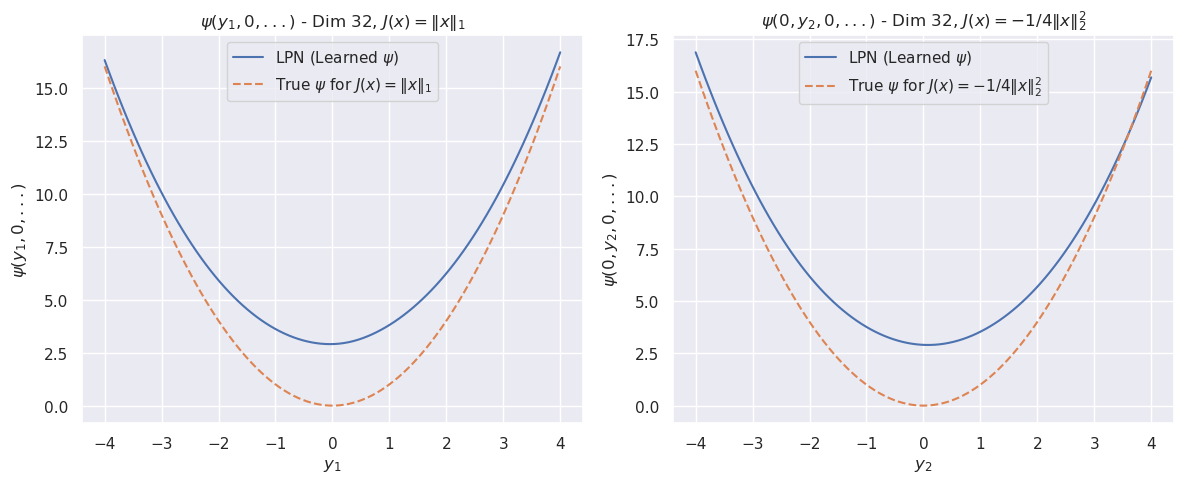

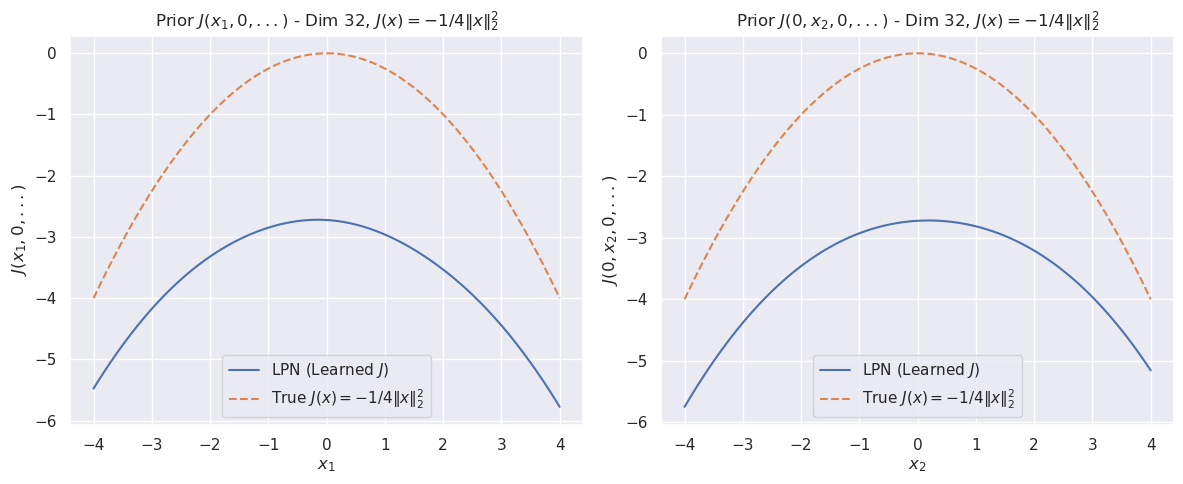

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.1519,  2.9007, -7.6109,  ...,  6.0386, -5.8782, -1.6489],
        [ 6.7824, -0.1231,  2.7810,  ..., -1.9040,  2.7254, -1.3706],
        [-7.6123,  1.2131,  2.5763,  ...,  0.8755, -1.4200, -4.4728],
        ...,
        [-5.6048,  5.1085,  7.1808,  ...,  0.2757,  0.5617,  0.4571],
        [ 0.1750, -6.2704,  5.5915,  ..., -3.0936, -2.4994,  6.0860],
        [-7.4747, -5.0087, -3.8291,  ..., -2.5477,  0.2301, -0.9441]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] /5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 27450.974609375
iteration 0 loss 10195.7041015625


iteration 500 loss 138.1531524658203


iteration 1000 loss 118.06201934814453


iteration 1500 loss 111.64818572998047


iteration 2000 loss 108.66130065917969


iteration 2500 loss 105.81078338623047


iteration 3000 loss 102.70037078857422


iteration 3500 loss 99.3436508178711


iteration 4000 loss 95.74798583984375


iteration 4500 loss 91.93231964111328


iteration 5000 loss 87.87442016601562


iteration 5500 loss 83.54801177978516


iteration 6000 loss 78.8497543334961


iteration 6500 loss 73.54752349853516


iteration 7000 loss 66.89926147460938


iteration 7500 loss 56.437923431396484


iteration 8000 loss 35.359561920166016


iteration 8500 loss 17.051406860351562


iteration 9000 loss 10.582356452941895


iteration 9500 loss 7.496531009674072


iteration 10000 loss 33.23978042602539


iteration 10500 loss 5.223232746124268


iteration 11000 loss 4.725893020629883


iteration 11500 loss 4.202960968017578


iteration 12000 loss 3.6659886837005615


iteration 12500 loss 3.1418890953063965


iteration 13000 loss 2.6477086544036865


iteration 13500 loss 2.529374837875366


iteration 14000 loss 2.406254529953003


iteration 14500 loss 2.266571044921875


iteration 15000 loss 2.109112501144409


iteration 15500 loss 1.9358112812042236


iteration 16000 loss 1.751636266708374


iteration 16500 loss 1.6151585578918457


iteration 17000 loss 1.5669540166854858


iteration 17500 loss 1.5213779211044312


iteration 18000 loss 1.4679110050201416


iteration 18500 loss 1.4049009084701538


iteration 19000 loss 1.3315922021865845


iteration 19500 loss 1.248258352279663


iteration 20000 loss 23.846248626708984


iteration 20500 loss 1.142095923423767


iteration 21000 loss 1.1187047958374023


iteration 21500 loss 1.0918909311294556


iteration 22000 loss 1.0598788261413574


iteration 22500 loss 1.0218573808670044


iteration 23000 loss 0.9774675369262695


iteration 23500 loss 0.9273839592933655


iteration 24000 loss 0.9005003571510315


iteration 24500 loss 0.8816251754760742


iteration 25000 loss 0.8600661158561707


iteration 25500 loss 0.8342222571372986


iteration 26000 loss 0.8034691214561462


iteration 26500 loss 0.786981999874115


iteration 27000 loss 0.763570249080658


iteration 27500 loss 0.751089334487915


iteration 28000 loss 0.7361836433410645


iteration 28500 loss 0.7179532051086426


iteration 29000 loss 0.6958749890327454


iteration 29500 loss 0.669918417930603


iteration 30000 loss 0.6642130613327026


iteration 30500 loss 0.65533846616745


iteration 31000 loss 0.6464680433273315


iteration 31500 loss 0.635865330696106


iteration 32000 loss 0.6228769421577454


iteration 32500 loss 0.607037365436554


iteration 33000 loss 0.588291585445404


iteration 33500 loss 0.5818843841552734


iteration 34000 loss 0.5740296840667725


iteration 34500 loss 0.5663142800331116


iteration 35000 loss 0.5570390224456787


iteration 35500 loss 0.5456133484840393


iteration 36000 loss 0.5317173600196838


iteration 36500 loss 0.5275360941886902


iteration 37000 loss 0.5175946950912476


iteration 37500 loss 0.5119001269340515


iteration 38000 loss 0.5058040022850037


iteration 38500 loss 0.4984591603279114


iteration 39000 loss 0.4894068241119385


iteration 39500 loss 0.4783251881599426


iteration 40000 loss 0.4767109155654907


iteration 40500 loss 0.46273157000541687


iteration 41000 loss 0.4565630257129669


iteration 41500 loss 0.4493628740310669


iteration 42000 loss 0.4405301511287689


iteration 42500 loss 0.4300488531589508


iteration 43000 loss 0.42986512184143066


iteration 43500 loss 0.42509979009628296


iteration 44000 loss 0.42095330357551575


iteration 44500 loss 0.4162296652793884


iteration 45000 loss 0.410480260848999


iteration 45500 loss 0.40343260765075684


iteration 46000 loss 0.3949906527996063


iteration 46500 loss 0.3936060070991516


iteration 47000 loss 0.38868221640586853


iteration 47500 loss 0.38491538166999817


iteration 48000 loss 0.3806849420070648


iteration 48500 loss 0.3755108714103699


iteration 49000 loss 0.36913856863975525


iteration 49500 loss 0.36198899149894714


iteration 50000 loss 0.36225083470344543


iteration 50500 loss 0.3584679663181305


iteration 51000 loss 0.3553638458251953


iteration 51500 loss 0.35192978382110596


iteration 52000 loss 0.34777867794036865


iteration 52500 loss 0.34268641471862793


iteration 53000 loss 0.33658501505851746


iteration 53500 loss 0.3379840850830078


iteration 54000 loss 0.3327940106391907


iteration 54500 loss 0.3298415541648865


iteration 55000 loss 0.3270992934703827


iteration 55500 loss 0.3239762485027313


iteration 56000 loss 0.32017844915390015


iteration 56500 loss 0.31552937626838684


iteration 57000 loss 0.3109040856361389


iteration 57500 loss 0.31132805347442627


iteration 58000 loss 0.30814120173454285


iteration 58500 loss 0.3057751953601837


iteration 59000 loss 0.30329903960227966


iteration 59500 loss 0.30036693811416626


iteration 60000 loss 0.2967787981033325


iteration 60500 loss 0.29238563776016235


iteration 61000 loss 0.29358673095703125


iteration 61500 loss 0.28974828124046326


iteration 62000 loss 0.28752583265304565


iteration 62500 loss 0.28540685772895813


iteration 63000 loss 0.2829580307006836


iteration 63500 loss 0.27997544407844543


iteration 64000 loss 0.2762811481952667


iteration 64500 loss 0.27991750836372375


iteration 65000 loss 0.2737736701965332


iteration 65500 loss 0.2714340090751648


iteration 66000 loss 0.26951444149017334


iteration 66500 loss 0.26743435859680176


iteration 67000 loss 0.2649269104003906


iteration 67500 loss 0.26184412837028503


iteration 68000 loss 0.2581223249435425


iteration 68500 loss 0.2592834532260895


iteration 69000 loss 0.2566337585449219


iteration 69500 loss 0.25486046075820923


iteration 70000 loss 0.2530859112739563


iteration 70500 loss 0.25100937485694885


iteration 71000 loss 0.2484777271747589


iteration 71500 loss 0.245553120970726


iteration 72000 loss 0.24744340777397156


iteration 72500 loss 0.24377323687076569


iteration 73000 loss 0.24187824130058289


iteration 73500 loss 0.24024496972560883


iteration 74000 loss 0.23844213783740997


iteration 74500 loss 0.23626630008220673


iteration 75000 loss 0.2336636632680893


iteration 75500 loss 0.23649078607559204


iteration 76000 loss 0.2323562502861023


iteration 76500 loss 0.23050087690353394


iteration 77000 loss 0.2290201634168625


iteration 77500 loss 0.22744886577129364


iteration 78000 loss 0.22558113932609558


iteration 78500 loss 0.22339984774589539


iteration 79000 loss 0.22956348955631256


iteration 79500 loss 0.2222459465265274


iteration 80000 loss 0.22031746804714203


iteration 80500 loss 0.21891838312149048


iteration 81000 loss 0.21750032901763916


iteration 81500 loss 0.2158437967300415


iteration 82000 loss 0.21383045613765717


iteration 82500 loss 0.36672544479370117


iteration 83000 loss 0.21310287714004517


iteration 83500 loss 0.21110616624355316


iteration 84000 loss 0.20977433025836945


iteration 84500 loss 0.20848746597766876


iteration 85000 loss 0.20701371133327484


iteration 85500 loss 0.2052212357521057


iteration 86000 loss 0.20303066074848175


iteration 86500 loss 0.20348460972309113


iteration 87000 loss 0.20166446268558502


iteration 87500 loss 0.2003270983695984


iteration 88000 loss 0.1988609880208969


iteration 88500 loss 0.1970805674791336


iteration 89000 loss 0.382050096988678


iteration 89500 loss 0.1967446506023407


iteration 90000 loss 0.19481362402439117


iteration 90500 loss 0.19359838962554932


iteration 91000 loss 0.19248078763484955


iteration 91500 loss 0.19122694432735443


iteration 92000 loss 0.1897086650133133


iteration 92500 loss 0.187897190451622


iteration 93000 loss 0.18867121636867523


iteration 93500 loss 0.1869432032108307


iteration 94000 loss 0.18586575984954834


iteration 94500 loss 0.18478608131408691


iteration 95000 loss 0.18351341784000397


iteration 95500 loss 0.18195874989032745


iteration 96000 loss 0.18320080637931824


iteration 96500 loss 0.18085210025310516


iteration 97000 loss 0.17975549399852753


iteration 97500 loss 0.17876209318637848


iteration 98000 loss 0.17762109637260437


iteration 98500 loss 0.17622074484825134


iteration 99000 loss 0.17956401407718658


iteration 99500 loss 0.17490340769290924


Learning rate decreased to 2e-05 at iteration 100000
iteration 100000 loss 0.17370004951953888


iteration 100500 loss 0.17347599565982819


iteration 101000 loss 0.17320764064788818


iteration 101500 loss 0.17288188636302948


iteration 102000 loss 0.17248083651065826


iteration 102500 loss 0.17198358476161957


iteration 103000 loss 0.1713598072528839


iteration 103500 loss 0.1705740988254547


iteration 104000 loss 0.16958317160606384


iteration 104500 loss 0.16833651065826416


iteration 105000 loss 0.16679389774799347


iteration 105500 loss 0.16602377593517303


iteration 106000 loss 0.16554199159145355


iteration 106500 loss 0.16509592533111572


iteration 107000 loss 0.16454555094242096


iteration 107500 loss 0.16384997963905334


iteration 108000 loss 0.16296981275081635


iteration 108500 loss 0.16185839474201202


iteration 109000 loss 0.16048766672611237


iteration 109500 loss 0.15964849293231964


iteration 110000 loss 0.1589951515197754


iteration 110500 loss 0.1585991233587265


iteration 111000 loss 0.1581253558397293


iteration 111500 loss 0.15752756595611572


iteration 112000 loss 0.15677155554294586


iteration 112500 loss 0.15581925213336945


iteration 113000 loss 0.15463288128376007


iteration 113500 loss 0.15516726672649384


iteration 114000 loss 0.15311872959136963


iteration 114500 loss 0.15276114642620087


iteration 115000 loss 0.15232838690280914


iteration 115500 loss 0.15178082883358002


iteration 116000 loss 0.15108579397201538


iteration 116500 loss 0.1502080112695694


iteration 117000 loss 0.14910988509655


iteration 117500 loss 0.14895592629909515


iteration 118000 loss 0.14770616590976715


iteration 118500 loss 0.14738330245018005


iteration 119000 loss 0.14700210094451904


iteration 119500 loss 0.14651994407176971


iteration 120000 loss 0.14590780436992645


iteration 120500 loss 0.14513173699378967


iteration 121000 loss 0.14416147768497467


iteration 121500 loss 0.1429648995399475


iteration 122000 loss 0.14264674484729767


iteration 122500 loss 0.14234061539173126


iteration 123000 loss 0.141997829079628


iteration 123500 loss 0.14156697690486908


iteration 124000 loss 0.14102055132389069


iteration 124500 loss 0.14032766222953796


iteration 125000 loss 0.1394547075033188


iteration 125500 loss 0.1383778601884842


iteration 126000 loss 0.13807228207588196


iteration 126500 loss 0.1377568542957306


iteration 127000 loss 0.1374562680721283


iteration 127500 loss 0.13708674907684326


iteration 128000 loss 0.13661864399909973


iteration 128500 loss 0.13602416217327118


iteration 129000 loss 0.13527226448059082


iteration 129500 loss 0.13433437049388885


iteration 130000 loss 0.1337127834558487


iteration 130500 loss 0.13335879147052765


iteration 131000 loss 0.13299252092838287


iteration 131500 loss 0.13253070414066315


iteration 132000 loss 0.13194426894187927


iteration 132500 loss 0.1312030404806137


iteration 133000 loss 0.13028059899806976


iteration 133500 loss 0.1299869418144226


iteration 134000 loss 0.12971952557563782


iteration 134500 loss 0.1294533759355545


iteration 135000 loss 0.1291232854127884


iteration 135500 loss 0.1287042498588562


iteration 136000 loss 0.1281716227531433


iteration 136500 loss 0.12750205397605896


iteration 137000 loss 0.12665598094463348


iteration 137500 loss 0.12632374465465546


iteration 138000 loss 0.12599502503871918


iteration 138500 loss 0.1257506012916565


iteration 139000 loss 0.12545830011367798


iteration 139500 loss 0.12508940696716309


iteration 140000 loss 0.12462062388658524


iteration 140500 loss 0.12402636557817459


iteration 141000 loss 0.12328454107046127


iteration 141500 loss 0.12287155538797379


iteration 142000 loss 0.12243609130382538


iteration 142500 loss 0.12221493571996689


iteration 143000 loss 0.12195181846618652


iteration 143500 loss 0.12161984294652939


iteration 144000 loss 0.12119810283184052


iteration 144500 loss 0.12066302448511124


iteration 145000 loss 0.11998999863862991


iteration 145500 loss 0.11979345232248306


iteration 146000 loss 0.11915137618780136


iteration 146500 loss 0.11894553899765015


iteration 147000 loss 0.1187053695321083


iteration 147500 loss 0.11840300261974335


iteration 148000 loss 0.11801880598068237


iteration 148500 loss 0.11753097921609879


iteration 149000 loss 0.11692580580711365


iteration 149500 loss 0.1161571517586708


iteration 150000 loss 0.1159859374165535


iteration 150500 loss 0.1157643273472786


iteration 151000 loss 0.1155034601688385


iteration 151500 loss 0.11517337709665298


iteration 152000 loss 0.11475329101085663


iteration 152500 loss 0.11422206461429596


iteration 153000 loss 0.11354875564575195


iteration 153500 loss 0.11325021833181381


iteration 154000 loss 0.11301135271787643


iteration 154500 loss 0.11276446282863617


iteration 155000 loss 0.11245507746934891


iteration 155500 loss 0.11206171661615372


iteration 156000 loss 0.11156728118658066


iteration 156500 loss 0.11093776673078537


iteration 157000 loss 0.11071991920471191


iteration 157500 loss 0.11047598719596863


iteration 158000 loss 0.11029015481472015


iteration 158500 loss 0.11006735265254974


iteration 159000 loss 0.10978584736585617


iteration 159500 loss 0.10942709445953369


iteration 160000 loss 0.10897055268287659


iteration 160500 loss 0.10839668661355972


iteration 161000 loss 0.10825562477111816


iteration 161500 loss 0.10785561054944992


iteration 162000 loss 0.10767695307731628


iteration 162500 loss 0.10748270153999329


iteration 163000 loss 0.10724137723445892


iteration 163500 loss 0.10693465173244476


iteration 164000 loss 0.10654394328594208


iteration 164500 loss 0.10605019330978394


iteration 165000 loss 0.10545071959495544


iteration 165500 loss 0.10531029105186462


iteration 166000 loss 0.10512365400791168


iteration 166500 loss 0.1049434021115303


iteration 167000 loss 0.1047208234667778


iteration 167500 loss 0.10443869233131409


iteration 168000 loss 0.1040797084569931


iteration 168500 loss 0.10362450778484344


iteration 169000 loss 0.10305790603160858


iteration 169500 loss 0.10291270166635513


iteration 170000 loss 0.10272209346294403


iteration 170500 loss 0.10256122797727585


iteration 171000 loss 0.102366603910923


iteration 171500 loss 0.10211995244026184


iteration 172000 loss 0.10180578380823135


iteration 172500 loss 0.10140570998191833


iteration 173000 loss 0.10090570151805878


iteration 173500 loss 0.10062292218208313


iteration 174000 loss 0.10037370026111603


iteration 174500 loss 0.10021011531352997


iteration 175000 loss 0.10001145303249359


iteration 175500 loss 0.09975957125425339


iteration 176000 loss 0.09943827986717224


iteration 176500 loss 0.09902984648942947


iteration 177000 loss 0.09851652383804321


iteration 177500 loss 0.09833040833473206


iteration 178000 loss 0.0981435775756836


iteration 178500 loss 0.09797317534685135


iteration 179000 loss 0.09776335209608078


iteration 179500 loss 0.09749643504619598


iteration 180000 loss 0.09715602546930313


iteration 180500 loss 0.09672527760267258


iteration 181000 loss 0.3155319392681122


iteration 181500 loss 0.09617088735103607


iteration 182000 loss 0.0960153266787529


iteration 182500 loss 0.09586405754089355


iteration 183000 loss 0.09567851573228836


iteration 183500 loss 0.09544368088245392


iteration 184000 loss 0.09514478594064713


iteration 184500 loss 0.09476865828037262


iteration 185000 loss 0.09430713951587677


iteration 185500 loss 0.09407038241624832


iteration 186000 loss 0.09388954937458038


iteration 186500 loss 0.09371627867221832


iteration 187000 loss 0.09350036829710007


iteration 187500 loss 0.09322539716959


iteration 188000 loss 0.09287596493959427


iteration 188500 loss 0.09243372827768326


iteration 189000 loss 0.09234652668237686


iteration 189500 loss 0.09207069873809814


iteration 190000 loss 0.09193189442157745


iteration 190500 loss 0.09177935868501663


iteration 191000 loss 0.0915895402431488


iteration 191500 loss 0.09134860336780548


iteration 192000 loss 0.09104575216770172


iteration 192500 loss 0.0906553864479065


iteration 193000 loss 0.09224074333906174


iteration 193500 loss 0.09021998941898346


iteration 194000 loss 0.09006933122873306


iteration 194500 loss 0.08993323892354965


iteration 195000 loss 0.08976969867944717


iteration 195500 loss 0.08956371992826462


iteration 196000 loss 0.08930166065692902


iteration 196500 loss 0.0889701247215271


iteration 197000 loss 0.08856293559074402


iteration 197500 loss 0.08845935016870499


iteration 198000 loss 0.08823305368423462


iteration 198500 loss 0.08810452371835709


iteration 199000 loss 0.0879596620798111


iteration 199500 loss 0.08777879178524017


Learning rate decreased to 4.000000000000001e-06 at iteration 200000
iteration 200000 loss 0.08754896372556686


iteration 200500 loss 0.08748958259820938


iteration 201000 loss 0.08741408586502075


iteration 201500 loss 0.08731785416603088


iteration 202000 loss 0.08719436079263687


iteration 202500 loss 0.08703631162643433


iteration 203000 loss 0.08683474361896515


iteration 203500 loss 0.08657803386449814


iteration 204000 loss 0.08625280857086182


iteration 204500 loss 0.08584626019001007


iteration 205000 loss 0.08563350886106491


iteration 205500 loss 0.08554662019014359


iteration 206000 loss 0.08543703705072403


iteration 206500 loss 0.08529655635356903


iteration 207000 loss 0.08511751145124435


iteration 207500 loss 0.08488914370536804


iteration 208000 loss 0.08459895104169846


iteration 208500 loss 0.08423428982496262


iteration 209000 loss 0.08393077552318573


iteration 209500 loss 0.08384877443313599


iteration 210000 loss 0.08374840766191483


iteration 210500 loss 0.08362005650997162


iteration 211000 loss 0.08345624804496765


iteration 211500 loss 0.08324718475341797


iteration 212000 loss 0.08298155665397644


iteration 212500 loss 0.08264637738466263


iteration 213000 loss 0.08227995038032532


iteration 213500 loss 0.0821535587310791


iteration 214000 loss 0.08200203627347946


iteration 214500 loss 0.08180885761976242


iteration 215000 loss 0.08156289160251617


iteration 215500 loss 0.08125167340040207


iteration 216000 loss 0.08088120073080063


iteration 216500 loss 0.0807933583855629


iteration 217000 loss 0.08071016520261765


iteration 217500 loss 0.0806041955947876


iteration 218000 loss 0.08046876639127731


iteration 218500 loss 0.08029597252607346


iteration 219000 loss 0.08007586747407913


iteration 219500 loss 0.07979650050401688


iteration 220000 loss 0.07944652438163757


iteration 220500 loss 0.07925105839967728


iteration 221000 loss 0.07916975021362305


iteration 221500 loss 0.07906652987003326


iteration 222000 loss 0.0789344310760498


iteration 222500 loss 0.0787658542394638


iteration 223000 loss 0.07855086773633957


iteration 223500 loss 0.07827793806791306


iteration 224000 loss 0.07793595641851425


iteration 224500 loss 0.07775943726301193


iteration 225000 loss 0.0776543915271759


iteration 225500 loss 0.07752028852701187


iteration 226000 loss 0.07734940946102142


iteration 226500 loss 0.07713159173727036


iteration 227000 loss 0.07685545831918716


iteration 227500 loss 0.07651069015264511


iteration 228000 loss 0.07637842744588852


iteration 228500 loss 0.07625662535429001


iteration 229000 loss 0.07610120624303818


iteration 229500 loss 0.0759027823805809


iteration 230000 loss 0.07565075159072876


iteration 230500 loss 0.0753336250782013


iteration 231000 loss 0.07516974210739136


iteration 231500 loss 0.07510186731815338


iteration 232000 loss 0.07501685619354248


iteration 232500 loss 0.07490795105695724


iteration 233000 loss 0.07476898282766342


iteration 233500 loss 0.07459153980016708


iteration 234000 loss 0.07436613738536835


iteration 234500 loss 0.07408200204372406


iteration 235000 loss 0.07384200394153595


iteration 235500 loss 0.07377763837575912


iteration 236000 loss 0.07370112091302872


iteration 236500 loss 0.07360324263572693


iteration 237000 loss 0.07347799092531204


iteration 237500 loss 0.07331845164299011


iteration 238000 loss 0.0731150284409523


iteration 238500 loss 0.07285789400339127


iteration 239000 loss 0.0726533830165863


iteration 239500 loss 0.0724908709526062


iteration 240000 loss 0.07242197543382645


iteration 240500 loss 0.07233409583568573


iteration 241000 loss 0.07222148776054382


iteration 241500 loss 0.07207793742418289


iteration 242000 loss 0.07189494371414185


iteration 242500 loss 0.07166291028261185


iteration 243000 loss 0.07137128710746765


iteration 243500 loss 0.071222685277462


iteration 244000 loss 0.07111530750989914


iteration 244500 loss 0.0709785521030426


iteration 245000 loss 0.07080376893281937


iteration 245500 loss 0.07058168202638626


iteration 246000 loss 0.07030206173658371


iteration 246500 loss 0.0701751783490181


iteration 247000 loss 0.07011573016643524


iteration 247500 loss 0.07004044204950333


iteration 248000 loss 0.06994396448135376


iteration 248500 loss 0.06982074677944183


iteration 249000 loss 0.06966343522071838


iteration 249500 loss 0.06946331262588501


iteration 250000 loss 0.06921088695526123


iteration 250500 loss 0.06900263577699661


iteration 251000 loss 0.06891115754842758


iteration 251500 loss 0.06879512965679169


iteration 252000 loss 0.068647101521492


iteration 252500 loss 0.06845840811729431


iteration 253000 loss 0.06822038441896439


iteration 253500 loss 0.0680101215839386


iteration 254000 loss 0.06795305013656616


iteration 254500 loss 0.06788866966962814


iteration 255000 loss 0.06780658662319183


iteration 255500 loss 0.06770142912864685


iteration 256000 loss 0.06756726652383804


iteration 256500 loss 0.06739621609449387


iteration 257000 loss 0.06717965006828308


iteration 257500 loss 0.06938763707876205


iteration 258000 loss 0.06686799973249435


iteration 258500 loss 0.0668114572763443


iteration 259000 loss 0.06673981994390488


iteration 259500 loss 0.06664811819791794


iteration 260000 loss 0.06653087586164474


iteration 260500 loss 0.06638132035732269


iteration 261000 loss 0.06619109958410263


iteration 261500 loss 0.06595120579004288


iteration 262000 loss 0.06581941992044449


iteration 262500 loss 0.06576801836490631


iteration 263000 loss 0.06570406258106232


iteration 263500 loss 0.06562217324972153


iteration 264000 loss 0.06551733613014221


iteration 264500 loss 0.06538358330726624


iteration 265000 loss 0.06521306186914444


iteration 265500 loss 0.0649971142411232


iteration 266000 loss 0.06479870527982712


iteration 266500 loss 0.06474422663450241


iteration 267000 loss 0.06468894332647324


iteration 267500 loss 0.06461841613054276


iteration 268000 loss 0.06452818214893341


iteration 268500 loss 0.06441254913806915


iteration 269000 loss 0.06426507979631424


iteration 269500 loss 0.06407757103443146


iteration 270000 loss 0.06384152919054031


iteration 270500 loss 0.06373512744903564


iteration 271000 loss 0.0636586919426918


iteration 271500 loss 0.06356104463338852


iteration 272000 loss 0.06343641132116318


iteration 272500 loss 0.06327743083238602


iteration 273000 loss 0.0630757063627243


iteration 273500 loss 0.06288662552833557


iteration 274000 loss 0.06282934546470642


iteration 274500 loss 0.06277823448181152


iteration 275000 loss 0.06271335482597351


iteration 275500 loss 0.06263014674186707


iteration 276000 loss 0.06252380460500717


iteration 276500 loss 0.06238787621259689


iteration 277000 loss 0.06221500784158707


iteration 277500 loss 0.06199689209461212


iteration 278000 loss 0.06187085434794426


iteration 278500 loss 0.06179116666316986


iteration 279000 loss 0.06168949604034424


iteration 279500 loss 0.06155960634350777


iteration 280000 loss 0.06139426678419113


iteration 280500 loss 0.061184752732515335


iteration 281000 loss 0.061057981103658676


iteration 281500 loss 0.06100494787096977


iteration 282000 loss 0.06093764677643776


iteration 282500 loss 0.060851335525512695


iteration 283000 loss 0.060741063207387924


iteration 283500 loss 0.06060022860765457


iteration 284000 loss 0.06042133644223213


iteration 284500 loss 0.060228146612644196


iteration 285000 loss 0.06015421077609062


iteration 285500 loss 0.06007976084947586


iteration 286000 loss 0.059984445571899414


iteration 286500 loss 0.05986270681023598


iteration 287000 loss 0.05970745533704758


iteration 287500 loss 0.05951116979122162


iteration 288000 loss 0.059387460350990295


iteration 288500 loss 0.059341929852962494


iteration 289000 loss 0.059285227209329605


iteration 289500 loss 0.05921252444386482


iteration 290000 loss 0.0591195672750473


iteration 290500 loss 0.059000711888074875


iteration 291000 loss 0.058849435299634933


iteration 291500 loss 0.058658208698034286


iteration 292000 loss 0.05853680148720741


iteration 292500 loss 0.058479614555835724


iteration 293000 loss 0.05840672552585602


iteration 293500 loss 0.05831356719136238


iteration 294000 loss 0.0581943579018116


iteration 294500 loss 0.05804239213466644


iteration 295000 loss 0.05785047635436058


iteration 295500 loss 0.05774281919002533


iteration 296000 loss 0.05767037719488144


iteration 296500 loss 0.057577840983867645


iteration 297000 loss 0.057459618896245956


iteration 297500 loss 0.05730874463915825


iteration 298000 loss 0.05711808428168297


iteration 298500 loss 0.05704963207244873


iteration 299000 loss 0.05700867623090744


iteration 299500 loss 0.056957684457302094


Learning rate decreased to 8.000000000000002e-07 at iteration 300000
iteration 300000 loss 0.05689222365617752


iteration 300500 loss 0.05687593296170235


iteration 301000 loss 0.056854575872421265


iteration 301500 loss 0.056826718151569366


iteration 302000 loss 0.05679101496934891


iteration 302500 loss 0.05674581602215767


iteration 303000 loss 0.056688304990530014


iteration 303500 loss 0.05661500245332718


iteration 304000 loss 0.05652216076850891


iteration 304500 loss 0.05640522763133049


iteration 305000 loss 0.05625942721962929


iteration 305500 loss 0.05608022212982178


iteration 306000 loss 0.05597449094057083


iteration 306500 loss 0.055851493030786514


iteration 307000 loss 0.05569813773036003


iteration 307500 loss 0.05553801730275154


iteration 308000 loss 0.05543718859553337


iteration 308500 loss 0.05531088635325432


iteration 309000 loss 0.055153727531433105


iteration 309500 loss 0.05501478165388107


iteration 310000 loss 0.054911740124225616


iteration 310500 loss 0.05478264018893242


iteration 311000 loss 0.05462266877293587


iteration 311500 loss 0.05451676994562149


iteration 312000 loss 0.0544467531144619


iteration 312500 loss 0.05435822531580925


iteration 313000 loss 0.05424676463007927


iteration 313500 loss 0.054107677191495895


iteration 314000 loss 0.0539439432322979


iteration 314500 loss 0.05386117845773697


iteration 315000 loss 0.053758665919303894


iteration 315500 loss 0.05363055318593979


iteration 316000 loss 0.053472135215997696


iteration 316500 loss 0.053377069532871246


iteration 317000 loss 0.05330290272831917


iteration 317500 loss 0.05320936068892479


iteration 318000 loss 0.053091861307621


iteration 318500 loss 0.052946049720048904


iteration 319000 loss 0.052828043699264526


iteration 319500 loss 0.05276486650109291


iteration 320000 loss 0.05268503725528717


iteration 320500 loss 0.052584268152713776


iteration 321000 loss 0.052458323538303375


iteration 321500 loss 0.05230299010872841


iteration 322000 loss 0.05223071947693825


iteration 322500 loss 0.052164264023303986


iteration 323000 loss 0.052080187946558


iteration 323500 loss 0.05197432264685631


iteration 324000 loss 0.051842328161001205


iteration 324500 loss 0.05169627070426941


iteration 325000 loss 0.051611486822366714


iteration 325500 loss 0.0515047088265419


iteration 326000 loss 0.05137169733643532


iteration 326500 loss 0.05123573914170265


iteration 327000 loss 0.05114690586924553


iteration 327500 loss 0.05103540048003197


iteration 328000 loss 0.05089686065912247


iteration 328500 loss 0.05079455301165581


iteration 329000 loss 0.0507417693734169


iteration 329500 loss 0.05067482963204384


iteration 330000 loss 0.0505901463329792


iteration 330500 loss 0.050483860075473785


iteration 331000 loss 0.05035170167684555


iteration 331500 loss 0.050237201154232025


iteration 332000 loss 0.05017850920557976


iteration 332500 loss 0.050104159861803055


iteration 333000 loss 0.05001061409711838


iteration 333500 loss 0.04989355430006981


iteration 334000 loss 0.04974918067455292


iteration 334500 loss 0.04966925084590912


iteration 335000 loss 0.04957904294133186


iteration 335500 loss 0.04946596547961235


iteration 336000 loss 0.0493260957300663


iteration 336500 loss 0.0492473728954792


iteration 337000 loss 0.049172159284353256


iteration 337500 loss 0.04907746985554695


iteration 338000 loss 0.04895920306444168


iteration 338500 loss 0.04882357642054558


iteration 339000 loss 0.04876519739627838


iteration 339500 loss 0.04869150370359421


iteration 340000 loss 0.04859877750277519


iteration 340500 loss 0.0484829843044281


iteration 341000 loss 0.04834819957613945


iteration 341500 loss 0.048294343054294586


iteration 342000 loss 0.04822612181305885


iteration 342500 loss 0.04814016446471214


iteration 343000 loss 0.04803231731057167


iteration 343500 loss 0.0478990375995636


iteration 344000 loss 0.04782037064433098


iteration 344500 loss 0.047743670642375946


iteration 345000 loss 0.04764726385474205


iteration 345500 loss 0.047527145594358444


iteration 346000 loss 0.04741862788796425


iteration 346500 loss 0.04734658822417259


iteration 347000 loss 0.04725591093301773


iteration 347500 loss 0.04714253172278404


iteration 348000 loss 0.04702238738536835


iteration 348500 loss 0.046975161880254745


iteration 349000 loss 0.046915143728256226


iteration 349500 loss 0.04683934152126312


iteration 350000 loss 0.046744152903556824


iteration 350500 loss 0.04662575572729111


iteration 351000 loss 0.04653473570942879


iteration 351500 loss 0.046488940715789795


iteration 352000 loss 0.046430811285972595


iteration 352500 loss 0.046357203274965286


iteration 353000 loss 0.04626478627324104


iteration 353500 loss 0.046149712055921555


iteration 354000 loss 0.04604773223400116


iteration 354500 loss 0.04598040506243706


iteration 355000 loss 0.04589563608169556


iteration 355500 loss 0.04578959196805954


iteration 356000 loss 0.045670878142118454


iteration 356500 loss 0.04560503736138344


iteration 357000 loss 0.045521948486566544


iteration 357500 loss 0.04541812092065811


iteration 358000 loss 0.045298982411623


iteration 358500 loss 0.04526355862617493


iteration 359000 loss 0.045219238847494125


iteration 359500 loss 0.04516294226050377


iteration 360000 loss 0.04509158059954643


iteration 360500 loss 0.04500186815857887


iteration 361000 loss 0.044890351593494415


iteration 361500 loss 0.04480007663369179


iteration 362000 loss 0.044750411063432693


iteration 362500 loss 0.044687286019325256


iteration 363000 loss 0.044607680290937424


iteration 363500 loss 0.04450806602835655


iteration 364000 loss 0.04439280927181244


iteration 364500 loss 0.04434903711080551


iteration 365000 loss 0.044293906539678574


iteration 365500 loss 0.04422421008348465


iteration 366000 loss 0.04413648694753647


iteration 366500 loss 0.04402734339237213


iteration 367000 loss 0.04395553097128868


iteration 367500 loss 0.04391810670495033


iteration 368000 loss 0.04387060925364494


iteration 368500 loss 0.04381033778190613


iteration 369000 loss 0.043734174221754074


iteration 369500 loss 0.04363885521888733


iteration 370000 loss 0.04352524131536484


iteration 370500 loss 0.04347243532538414


iteration 371000 loss 0.04340682923793793


iteration 371500 loss 0.04332420974969864


iteration 372000 loss 0.04322107881307602


iteration 372500 loss 0.04313846305012703


iteration 373000 loss 0.0430978462100029


iteration 373500 loss 0.043046124279499054


iteration 374000 loss 0.042980533093214035


iteration 374500 loss 0.04289805889129639


iteration 375000 loss 0.042795319110155106


iteration 375500 loss 0.04271571710705757


iteration 376000 loss 0.04266291856765747


iteration 376500 loss 0.042596008628606796


iteration 377000 loss 0.0425117164850235


iteration 377500 loss 0.042406994849443436


iteration 378000 loss 0.04234966263175011


iteration 378500 loss 0.04231375455856323


iteration 379000 loss 0.04226825013756752


iteration 379500 loss 0.04221033677458763


iteration 380000 loss 0.042137306183576584


iteration 380500 loss 0.042045824229717255


iteration 381000 loss 0.04194672778248787


iteration 381500 loss 0.04191237688064575


iteration 382000 loss 0.04186885431408882


iteration 382500 loss 0.041813477873802185


iteration 383000 loss 0.041743479669094086


iteration 383500 loss 0.04165579751133919


iteration 384000 loss 0.041558343917131424


iteration 384500 loss 0.041520263999700546


iteration 385000 loss 0.041481632739305496


iteration 385500 loss 0.04143247753381729


iteration 386000 loss 0.04137006774544716


iteration 386500 loss 0.04129165783524513


iteration 387000 loss 0.041193969547748566


iteration 387500 loss 0.041132938116788864


iteration 388000 loss 0.04110081493854523


iteration 388500 loss 0.04106014594435692


iteration 389000 loss 0.04100832715630531


iteration 389500 loss 0.04094269499182701


iteration 390000 loss 0.04086039215326309


iteration 390500 loss 0.04075818508863449


iteration 391000 loss 0.04071930795907974


iteration 391500 loss 0.040683191269636154


iteration 392000 loss 0.04063724726438522


iteration 392500 loss 0.0405789278447628


iteration 393000 loss 0.040505390614271164


iteration 393500 loss 0.04041358083486557


iteration 394000 loss 0.04034299775958061


iteration 394500 loss 0.040312305092811584


iteration 395000 loss 0.04027334973216057


iteration 395500 loss 0.040223684161901474


iteration 396000 loss 0.0401608906686306


iteration 396500 loss 0.04008183628320694


iteration 397000 loss 0.03998368978500366


iteration 397500 loss 0.03994501382112503


iteration 398000 loss 0.03991261124610901


iteration 398500 loss 0.03987140953540802


iteration 399000 loss 0.03981899470090866


iteration 399500 loss 0.03975272551178932


Learning rate decreased to 1.6000000000000003e-07 at iteration 400000
iteration 400000 loss 0.039669714868068695


iteration 400500 loss 0.03964877873659134


iteration 401000 loss 0.039622943848371506


iteration 401500 loss 0.03959159925580025


iteration 402000 loss 0.0395541675388813


iteration 402500 loss 0.03950987756252289


iteration 403000 loss 0.03945852443575859


iteration 403500 loss 0.03940020501613617


iteration 404000 loss 0.0393361933529377


iteration 404500 loss 0.03927205875515938


iteration 405000 loss 0.0392083041369915


iteration 405500 loss 0.03914507478475571


iteration 406000 loss 0.03908241540193558


iteration 406500 loss 0.03901996463537216


iteration 407000 loss 0.038958337157964706


iteration 407500 loss 0.03889668732881546


iteration 408000 loss 0.03883520886301994


iteration 408500 loss 0.038774192333221436


iteration 409000 loss 0.03871333226561546


iteration 409500 loss 0.03865278884768486


iteration 410000 loss 0.03859258443117142


iteration 410500 loss 0.03853322193026543


iteration 411000 loss 0.03847375512123108


iteration 411500 loss 0.03841445595026016


iteration 412000 loss 0.03835536912083626


iteration 412500 loss 0.03829650953412056


iteration 413000 loss 0.03823797032237053


iteration 413500 loss 0.03817968815565109


iteration 414000 loss 0.03812146931886673


iteration 414500 loss 0.03806343302130699


iteration 415000 loss 0.038005754351615906


iteration 415500 loss 0.03794810175895691


iteration 416000 loss 0.0378907285630703


iteration 416500 loss 0.03783363103866577


iteration 417000 loss 0.03777671232819557


iteration 417500 loss 0.03771993890404701


iteration 418000 loss 0.03766341507434845


iteration 418500 loss 0.03760708495974541


iteration 419000 loss 0.03755086287856102


iteration 419500 loss 0.037494879215955734


iteration 420000 loss 0.03743910789489746


iteration 420500 loss 0.03738361969590187


iteration 421000 loss 0.03732820227742195


iteration 421500 loss 0.03727288544178009


iteration 422000 loss 0.03721784055233002


iteration 422500 loss 0.037162914872169495


iteration 423000 loss 0.037108130753040314


iteration 423500 loss 0.03705377131700516


iteration 424000 loss 0.03699929639697075


iteration 424500 loss 0.03694497421383858


iteration 425000 loss 0.03689096122980118


iteration 425500 loss 0.03683725371956825


iteration 426000 loss 0.03678369149565697


iteration 426500 loss 0.036730121821165085


iteration 427000 loss 0.036676958203315735


iteration 427500 loss 0.03662363067269325


iteration 428000 loss 0.03657040745019913


iteration 428500 loss 0.036517467349767685


iteration 429000 loss 0.03646467626094818


iteration 429500 loss 0.03641188144683838


iteration 430000 loss 0.03635960817337036


iteration 430500 loss 0.036307208240032196


iteration 431000 loss 0.03625548258423805


iteration 431500 loss 0.03620326891541481


iteration 432000 loss 0.036151494830846786


iteration 432500 loss 0.036099571734666824


iteration 433000 loss 0.03604762628674507


iteration 433500 loss 0.035996854305267334


iteration 434000 loss 0.03594524413347244


iteration 434500 loss 0.035893797874450684


iteration 435000 loss 0.03584245964884758


iteration 435500 loss 0.035791508853435516


iteration 436000 loss 0.03574054315686226


iteration 436500 loss 0.03568967059254646


iteration 437000 loss 0.03563888743519783


iteration 437500 loss 0.035588279366493225


iteration 438000 loss 0.03553779795765877


iteration 438500 loss 0.0354873463511467


iteration 439000 loss 0.035437144339084625


iteration 439500 loss 0.035387072712183


iteration 440000 loss 0.03533700481057167


iteration 440500 loss 0.035286981612443924


iteration 441000 loss 0.03523717075586319


iteration 441500 loss 0.035187628120183945


iteration 442000 loss 0.035138074308633804


iteration 442500 loss 0.03508853167295456


iteration 443000 loss 0.03503921255469322


iteration 443500 loss 0.03498990088701248


iteration 444000 loss 0.03494084253907204


iteration 444500 loss 0.034892044961452484


iteration 445000 loss 0.0348433293402195


iteration 445500 loss 0.0347948893904686


iteration 446000 loss 0.034746360033750534


iteration 446500 loss 0.0346977636218071


iteration 447000 loss 0.034649431705474854


iteration 447500 loss 0.0346011184155941


iteration 448000 loss 0.03455296531319618


iteration 448500 loss 0.034504953771829605


iteration 449000 loss 0.03445696830749512


iteration 449500 loss 0.034409068524837494


iteration 450000 loss 0.03436131402850151


iteration 450500 loss 0.03431364893913269


iteration 451000 loss 0.03426619619131088


iteration 451500 loss 0.034218575805425644


iteration 452000 loss 0.03417123481631279


iteration 452500 loss 0.03412395715713501


iteration 453000 loss 0.03407678008079529


iteration 453500 loss 0.034029826521873474


iteration 454000 loss 0.03398288041353226


iteration 454500 loss 0.033936236053705215


iteration 455000 loss 0.03388949856162071


iteration 455500 loss 0.03384280949831009


iteration 456000 loss 0.03379635140299797


iteration 456500 loss 0.03374997526407242


iteration 457000 loss 0.033703673630952835


iteration 457500 loss 0.033657483756542206


iteration 458000 loss 0.03361138328909874


iteration 458500 loss 0.033565398305654526


iteration 459000 loss 0.03351949527859688


iteration 459500 loss 0.03347369283437729


iteration 460000 loss 0.03342793509364128


iteration 460500 loss 0.033382438123226166


iteration 461000 loss 0.03333690017461777


iteration 461500 loss 0.033291637897491455


iteration 462000 loss 0.03324635326862335


iteration 462500 loss 0.03320107236504555


iteration 463000 loss 0.033156007528305054


iteration 463500 loss 0.03311097249388695


iteration 464000 loss 0.033066004514694214


iteration 464500 loss 0.033021170645952225


iteration 465000 loss 0.0329764261841774


iteration 465500 loss 0.03293173015117645


iteration 466000 loss 0.03288712725043297


iteration 466500 loss 0.032842691987752914


iteration 467000 loss 0.032798297703266144


iteration 467500 loss 0.03275395557284355


iteration 468000 loss 0.032709669321775436


iteration 468500 loss 0.03266558423638344


iteration 469000 loss 0.032621584832668304


iteration 469500 loss 0.03257768601179123


iteration 470000 loss 0.032533783465623856


iteration 470500 loss 0.03249011188745499


iteration 471000 loss 0.03244641795754433


iteration 471500 loss 0.03240278363227844


iteration 472000 loss 0.032359275966882706


iteration 472500 loss 0.03231595829129219


iteration 473000 loss 0.032272543758153915


iteration 473500 loss 0.032229457050561905


iteration 474000 loss 0.032186359167099


iteration 474500 loss 0.03214314952492714


iteration 475000 loss 0.03210016340017319


iteration 475500 loss 0.03205728530883789


iteration 476000 loss 0.032014451920986176


iteration 476500 loss 0.03197186067700386


iteration 477000 loss 0.03192934766411781


iteration 477500 loss 0.03188692033290863


iteration 478000 loss 0.03184523060917854


iteration 478500 loss 0.03180339187383652


iteration 479000 loss 0.03176087141036987


iteration 479500 loss 0.03171861916780472


iteration 480000 loss 0.031676653772592545


iteration 480500 loss 0.031634941697120667


iteration 481000 loss 0.03159279376268387


iteration 481500 loss 0.031550779938697815


iteration 482000 loss 0.03150887414813042


iteration 482500 loss 0.03146706521511078


iteration 483000 loss 0.0314253568649292


iteration 483500 loss 0.031383611261844635


iteration 484000 loss 0.031341902911663055


iteration 484500 loss 0.03130045160651207


iteration 485000 loss 0.03125891461968422


iteration 485500 loss 0.0312175415456295


iteration 486000 loss 0.031176269054412842


iteration 486500 loss 0.031134918332099915


iteration 487000 loss 0.031093794852495193


iteration 487500 loss 0.03105263039469719


iteration 488000 loss 0.03101162612438202


iteration 488500 loss 0.030970625579357147


iteration 489000 loss 0.03092978522181511


iteration 489500 loss 0.03088901937007904


iteration 490000 loss 0.030848296359181404


iteration 490500 loss 0.030807631090283394


iteration 491000 loss 0.030767040327191353


iteration 491500 loss 0.03072638250887394


iteration 492000 loss 0.03068600967526436


iteration 492500 loss 0.0306455809623003


iteration 493000 loss 0.030605187639594078


iteration 493500 loss 0.030564995482563972


iteration 494000 loss 0.03052481636404991


iteration 494500 loss 0.03048470988869667


iteration 495000 loss 0.030444592237472534


iteration 495500 loss 0.03040464036166668


iteration 496000 loss 0.03036472015082836


iteration 496500 loss 0.030324865132570267


iteration 497000 loss 0.030285203829407692


iteration 497500 loss 0.030245501548051834


iteration 498000 loss 0.030205853283405304


iteration 498500 loss 0.030166245996952057


iteration 499000 loss 0.030126817524433136


iteration 499500 loss 0.030087444931268692


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


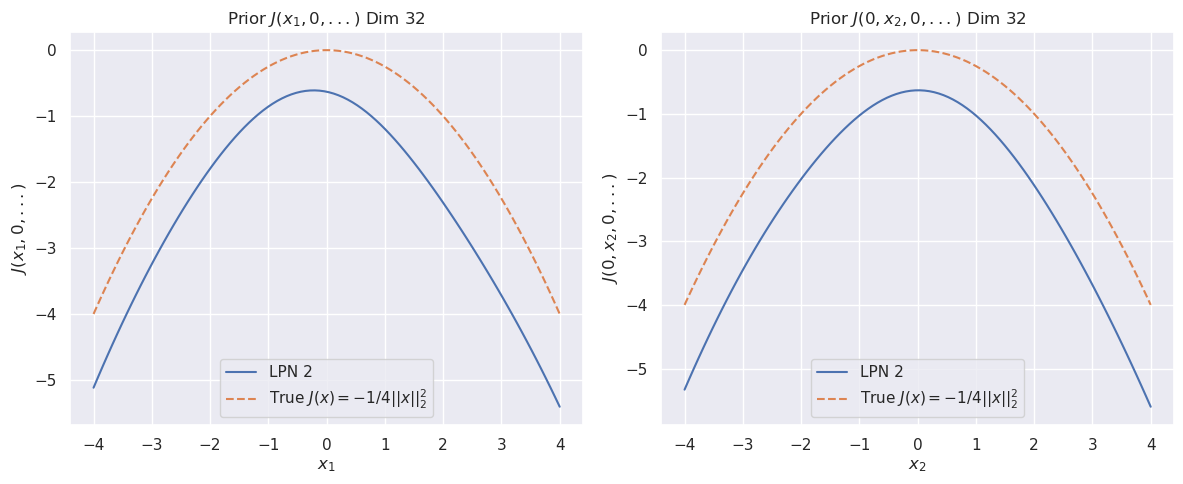

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)